# Notebook examples for Chapter 9
# Change Detection
When comparing multispectral images of a given scene taken
at different times, it is  desirable to correct the pixel
intensities as much as possible for uninteresting differences such
as those due to solar illumination, atmospheric conditions, viewing angle, terrain effects or sensor
calibration. In the case of SAR imagery, solar illumination or cloud cover play no role, but other considerations are similarly important.
If comparison is on a pixel-by-pixel basis, then the
images must also be co-registered to high accuracy in order to
avoid spurious signals resulting from misalignment. Some of
the required preprocessing steps were discussed in Chapter 5. 
After having performed the necessary preprocessing, it is common
to examine various functions of the spectral bands involved
(differences, ratios or linear combinations) which in some way
bring the change information contained within them to the fore.
Large changes are often evident at a glance. However, other changes may
have occurred between the acquisition times and require more image processing to be clearly distinguished. This Chapter describes some commonly used  techniques for enhancing
change signals in bi-temporal satellite images and then focuses attention  on the  _multivariate alteration
detection_ (MAD) algorithm  for visible/infrared imagery and on a sequential change statistic for polarimetric SAR data based on the complex Wishart distribution. The Chapter
concludes with an inverse application of change detection,
in which _unchanged_ pixels are used for automatic
relative radiometric normalization of multi-temporal imagery.

In [1]:
import ee
#ee.Authenticate()
ee.Initialize()
%matplotlib inline

In [2]:
run auxil/subset -d [200,200,1000,1000] imagery/LT5_19980516.tif 

Spatial/spectral subsetting
Fri Nov  8 12:36:39 2024
Input imagery/LT5_19980516.tif
elapsed time: 0.2942657470703125
Subset image written to: imagery/LT5_19980516_sub.tif


In [3]:
run auxil/subset -d [200,200,1000,1000] imagery/LT5_19980329.tif 

Spatial/spectral subsetting
Fri Nov  8 12:36:44 2024
Input imagery/LT5_19980329.tif
elapsed time: 0.2770829200744629
Subset image written to: imagery/LT5_19980329_sub.tif


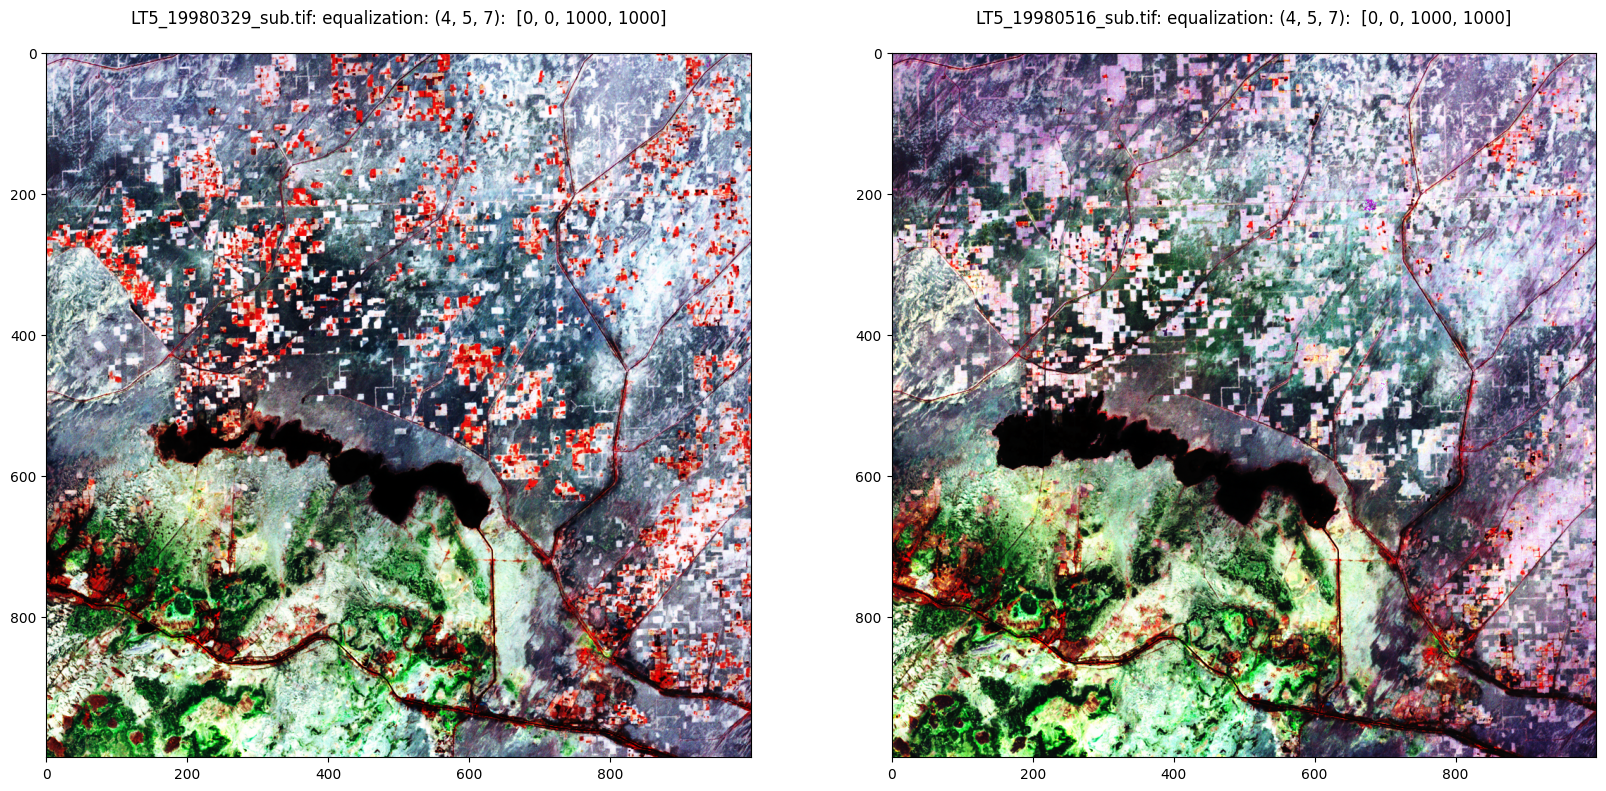

<Figure size 640x480 with 0 Axes>

In [4]:
%run scripts/dispms -f imagery/LT5_19980329_sub.tif -e 4 -p [4,5,7] \
-F imagery/LT5_19980516_sub.tif -E 4 -P [4,5,7] \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter9/fig9_1.eps'

## 9.1 Naive methods

In [ ]:
import ee
import IPython.display as disp

ee.Initialize()

im1 = ee.Image('projects/ee-mortcanty/assets/CRC5/LT5_19980329_sub')
im2 = ee.Image('projects/ee-mortcanty/assets/CRC5/LT5_19980516_sub')
ndvi1 = im1.normalizedDifference(['b4', 'b3'])
ndvi2 = im2.normalizedDifference(['b4', 'b3'])
url = ndvi1.subtract(ndvi2) \
   .getThumbURL({'min':-0.3,'max':0.3})
disp.Image(url=url)

## 9.2 Principal components analysis (PCA)
### 9.2.1 Iterated PCA

In [ ]:
import numpy as np
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import matplotlib.pyplot as plt

gdal.AllRegister()
infile = 'imagery/LT5_19980329.tif'                 
inDataset = gdal.Open(infile,GA_ReadOnly)     
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    
band = inDataset.GetRasterBand(4)  
G1 = band.ReadAsArray(0,0,cols,rows).flatten()
infile = 'imagery/LT5_19980516.tif'                 
inDataset = gdal.Open(infile,GA_ReadOnly)       
band = inDataset.GetRasterBand(4)  
G2 = band.ReadAsArray(0,0,cols,rows).flatten()
idx = np.random.randint(0,rows*cols,10000)
p = plt.plot(G1[idx],G2[idx],'.')
#plt.savefig('/home/mort/LaTeX/new projects/CRC5/Chapter9/fig9_3.eps',bbox_inches='tight')

In [ ]:
run scripts/ex9_1 imagery/LT5_19980329_sub.tif imagery/LT5_19980516_sub.tif

### 9.2.2 Kernel PCA

## 9.3 Multivariate Alteration Detection
### 9.3.1 Canonical correlation analysis (CCA)
### 9.3.2 Orthogonality properties
### 9.3.3 Iteratively re-weighted MAD

In [ ]:
# Run the iMAD transformation
%run scripts/iMad -i 50 imagery/LT5_19980329_sub.tif \
                         imagery/LT5_19980516_sub.tif
# Set a significance level and calculate change map
%run scripts/iMadmap -m \
imagery/MAD(LT5_19980329_sub-LT5_19980516_sub).tif 0.0001

In [ ]:
%run scripts/dispms -f imagery/MAD(LT5_19980329_sub-LT5_19980516_sub)_cmap.tif -e 3 -p [1,2,3] \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter9/fig9_6.eps'

### 9.3.4 Scale invariance
### 9.3.5 Regularization
### 9.3.6 Post processing
### 9.3.7 Unsupervised change classification

In [ ]:
%run scripts/dispms -f imagery/LE7_20010626.tif -e 3 -p[4,5,6] -F imagery/LE7_20010829.tif -E 3 -P [4,5,6] \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter9/fig9_8.eps'


In [ ]:
%run scripts/iMad -i 50 imagery/LE7_20010626.tif \
                         imagery/LE7_20010829.tif

In [ ]:
%run scripts/iMadmap imagery/MAD(LE7_20010626-LE7_20010829).tif 0.0001

In [ ]:
%run scripts/dispms -f imagery/MAD(LE7_20010626-LE7_20010829)_cmap.tif -e 4 -p [1,2,3] \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter9/fig9_9.eps'

In [ ]:
run scripts/em -K 4  imagery/MAD(LE7_20010626-LE7_20010829).tif

In [ ]:
%run scripts/dispms -f imagery/MAD(LE7_20010626-LE7_20010829)_em.tif -c -d [400,0,200,200] \
-F imagery/LE7_20010829 -E 4 -D [400,0,200,200] -P [4,4,4] \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter9/fig9_10.eps'

### 9.3.8 iMAD on the Google Earth Engine

In [ ]:
import ee, math, time
from ipyleaflet import (Map,DrawControl,TileLayer)
from auxil.eeMad import imad
ee.Initialize()

def handle_draw(self, action, geo_json):
    global poly
    if action == 'created':
        coords =  geo_json['geometry']['coordinates']
        poly = ee.Geometry.Polygon(coords)
        
dc = DrawControl()
dc.on_draw(handle_draw)

def GetTileLayerUrl(ee_image_object):
  map_id = ee.Image(ee_image_object).getMapId()
  tile_fetcher = map_id['tile_fetcher']
  return tile_fetcher.url_format    

#### Draw the map

In [ ]:
m = Map(center=[50.9, 6.4], zoom=11)
m.add_control(dc)

m

#### iMAD wrapper function

In [ ]:
def iMad(cid,poly,sd1,ed1,sd2,ed2,bns,maxitr):
    collection = ee.ImageCollection(cid) \
         .filterBounds(poly) \
         .filterDate(ee.Date(sd1), ee.Date(ed1)) \
         .sort('system:time_start',False)
    image1 = ee.Image(collection.first()).select(bns)
    collection = ee.ImageCollection(cid) \
         .filterBounds(poly) \
         .filterDate(ee.Date(sd2), ee.Date(ed2)) \
         .sort('system:time_start',False)                   
    image2 = ee.Image(collection.first()).select(bns) 
    image2 = image2.register(image1,60)
    inputlist = ee.List.sequence(1,maxitr)
    first = ee.Dictionary({'done':ee.Number(0),
          'image':image1.addBands(image2).clip(poly),
          'allrhos': [ee.List.sequence(1,len(bns))],
          'chi2':ee.Image.constant(0),
          'MAD':ee.Image.constant(0)}) 
    madnames = ['MAD'+str(i+1) for i in range(len(bns))]
#  run the algorithm    
    result = ee.Dictionary(inputlist.iterate(imad,first))                
    MAD = ee.Image(result.get('MAD')).rename(madnames)
    return MAD

#### Input data
Before executing this cell, select a polynomial on the map.

In [ ]:
collectionid = 'LANDSAT/LE07/C02/T1_RT_TOA'
bandNames = ['B1','B2','B3','B4','B5','B7']
startDate1 = '2001-06-25'
endDate1 = '2001-06-27'
startDate2 = '2001-08-28'
endDate2 = '2001-08-30'
maxitr = 50
MAD = iMad(collectionid,poly,startDate1,
           endDate1,startDate2,endDate2,
           bandNames,maxitr)

#### Display on map

In [ ]:
m.add_layer(
    TileLayer(url=GetTileLayerUrl(
        MAD.select('MAD1').visualize(min=-3, max=3) )) )

#### Export to assets

In [ ]:
assexportname = 'projects/<your project>/assets/<asset name>'
assexport = ee.batch.Export.image.toAsset(MAD,
           description='assetExportTask', 
           assetId=assexportname,scale=30,maxPixels=1e9)
assexportid = str(assexport.id)
print '****Exporting to Assets, task id: %s'%assexportid
assexport.start() 

## 9.4 Change detection with polarimetric SAR imagery
### 9.4.1 Scalar imagery: the gamma distribution
Bi-temporal data: The Frankfurt Airport and a subset with no-change

In [ ]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.473892211914062,
              49.98081240937428
            ],
            [
              8.658599853515625,
              49.98081240937428
            ],
            [
              8.658599853515625,
              50.06066538593667
            ],
            [
              8.473892211914062,
              50.06066538593667
            ],
            [
              8.473892211914062,
              49.98081240937428
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.534317016601562,
              50.021637833966786
            ],
            [
              8.530540466308594,
              49.99780882512238
            ],
            [
              8.564186096191406,
              50.00663576154257
            ],
            [
              8.578605651855469,
              50.019431940583104
            ],
            [
              8.534317016601562,
              50.021637833966786
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

Filter the S1 archive to get an image collection consisting of two images acquired in the month of August, 2020. Because we are interested in change detection, it is essential that the local incidence angles be the same in both images. So we specify both the orbit pass (ASCENDING) as well the relative orbit number (15):

In [ ]:
im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(aoi)
                .filterDate(ee.Date('2020-08-01'),ee.Date('2020-08-31'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 15))
                .sort('system:time_start'))
# acquisition times
import time
acq_times = im_coll.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

Select the first two images and extract the VV bands, clipping them to aoi_sub. Take their ratio and plot its histogram compared to the F-distribution with 2m and 2m degrees of freedom (m=5 in this case):

In [ ]:
from scipy.stats import norm, gamma, f, chi2

im_list = im_coll.toList(im_coll.size())
im1 = ee.Image(im_list.get(0)).select('VV').clip(aoi_sub)
im2 = ee.Image(im_list.get(1)).select('VV').clip(aoi_sub)

ratio = im1.divide(im2)

hist = ratio.reduceRegion(ee.Reducer.fixedHistogram(0, 5, 500), aoi_sub).get('VV').getInfo()
mean = ratio.reduceRegion(ee.Reducer.mean(), aoi_sub).get('VV').getInfo()
variance = ratio.reduceRegion(ee.Reducer.variance(), aoi_sub).get('VV').getInfo()

a = np.array(hist)
x = a[:, 0]                 # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1]) # normalized array of bucket contents

m = 5
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, f.pdf(x, 2*m, 2*m) / 100, '-r', label='F-dist')
plt.legend()
plt.show()

### 9.4.2 Polarimetric imagery: The complex Wishart distribution
### 9.4.3 Python software

In [ ]:
%run scripts/enlml.py -d [200,200,600,600] imagery/S1A_IW_SLC__1SDV_20141108T054351_20141108T054421_003186_003AB4_B367.tif

In [ ]:
%run scripts/dispms -f imagery/S1A_IW_SLC__1SDV_20141108T054351_20141108T054421_003186_003AB4_B367_enl.tif -e 2 -p [1,1,1] 

In [ ]:
!cat scripts/run_sar_seqQ.sh

In [ ]:
!ipcluster start -n 4 --daemonize

In [ ]:
# Dual pol Sentinel-1
!/bin/bash scripts/run_sar_seqQ.sh S1A imagery/ 12 0.0001

In [ ]:
%run scripts/dispms -f imagery/S1A_IW_SLC__1SDV_20141108T054351_20141108T054421_003186_003AB4_B367.tif -p [4,1,1] -d [200,200,600,600] \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter9/fig9_17.eps'

In [ ]:
%run scripts/dispms -f  imagery/sarseqQ_smap.tif -c -d [600,200,400,400] \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter9/fig9_18.eps'

In [ ]:
# Quad pol RadarSat-2
!/bin/bash scripts/run_sar_seqQ.sh T20 imagery/ 12 0.0001

In [ ]:
%run scripts/dispms -f imagery/sarseqQ_fmap.tif -c -d [200,200,400,400] \
-F imagery/T20100426.tif -P [1,6,9]  -D [200,200,400,400] \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter9/fig9_19.eps'

In [ ]:
# Dual pol Sentinel-1 diagonal only (as in GEE archive)
!/bin/bash scripts/run_sar_seqQ.sh Ta20 imagery/ 4.4 0.0001

In [ ]:
%run scripts/dispms -f imagery/sarseqQ_fmap.tif -c  \
-F imagery/Ta20180406_1.tif -P [2,1,1]  

In [ ]:
!ipcluster stop

## 9.4.4 SAR change detection on the Google Earth Engine

In [ ]:
## Run the interface.
import ee
ee.Initialize()
from auxil.application import run
run()

### How to use the interface

#### Caveat

*The sequential SAR change detection method that is described in Chapter 9, Section 9.4 is _pixel-oriented_. That is to say, it is based entirely on the statistical properties of each and every multi-look pixel in the observed image series. For this reason it is best to limit analysis to a region less than a few thousand square kilometers while interactively visualizing and exploring results using this notebook. Furthermore, since we are analysing time series for changes, the reflectance images involved must all completely overlap the region of interest and have been irradiated from the same position in space. This means choosing either ascending **or** descending node, and only **one** relative orbit number for any given sequence.*

#### Walk through

To get started, let's see how to generate a small change map. In the widget interface above, choose **Platform** A, leaving all other settings as is. Select a small area of interest (aoi) near the town of Jülich with the rectangular or polygon **draw tool**. This will enable the **Collect** button. Click it to collect an image series, the details of which are printed in the info box at the bottom. The raster overlay shows the complete swath of the last image in the sequence. When the overlay is fully rendered, the **Preview** button is enabled.

**Note:** Depending on the position of the aoi, two relative orbit numbers may be displayed (88 and 15). If so, in the corresponding **RelOrbit** field choose either of them and re-collect.

The **Preview** button will  now trigger the change detection algorithm at the scale selected by the current zoom setting. The color coded change map is displayed, showing, for each pixel, the interval within the series of the **First** detected change (palette = 'black, blue, cyan, yellow, red' indicating early in the series through to late). The map displayed is set by the Radio Button next to **Preview**.  Since processing is carried out in parallel, the change image is built up tile-by-tile. The zoom setting can falsify the result somewhat, depending on the pyramid level at which the calculation is carried out. Nevertheless it is often convenient for generating a quick overview. You can see the effect by zooming in and out. De-select the **QuickPreview** check box to override it. Now the calculation is carried out at the full 10 m pixel scale irrespective of the zoom level chosen, but can take considerably longer.

If and when you are satisfied with the previewed result, you can export the change maps to your GEE cloud assets with the **ExportToAssets**  or to your Google Drive with the **ExportToDrive** buttons, see below.

#### The widgets

**Platform:** Choose one or both of the Sentinel-1 satellites.

**Pass:** Choose ascending or descending node.

**RelOrbit:** Choose relative orbit number. If set to 0 all orbit numbers are included with images which overlap with the area of interest.

**StartDate:** Beginning of collected time series.

**EndDate:** End of collected time series.

**Collect:** Start collection, enabled when an area of interest has been chosen. Upon completion the last Sentinel-1 image in the sequence is displayed.

**Signif:** Choose a significance level for the [likelihood ratio test](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2#the_likelihood_ratio_test).

**MedianFilter:** Run a 3x3 median filter over the change map before displaying or exporting.

**Stride:** Select only a subset of the collected sequence. For example, the value 3 will collect every third image in the sequence.

**View:** Display the most cloud-free Sentinel-2 image or a NAIP image (available only within the continental US) found within the chosen time period.

**ExportToAssets:** Creates and runs a batch task to export a change map image as a raster to an Earth Engine asset.  For a time series of $k$ images, the exported change map consists of $k+2$ bands
- cmap: the interval* of the most recent change, one band, byte values $\in [0,k-1]$, where 0 = no change.
- smap: the interval of the first change, one band, byte values $\in [0,k-1]$, where 0 = no change.
- fmap: the number of changes, one band, byte values $\in [0,k-1]$, where 0 = no changes.
- bmap: the changes in each interval, $\ k-1$ bands, byte values $\in [0,3]$, where 0 = no change, 1 = positive definite change, 2 = negative definite change, 3 = indefinite change.

*Two successive acquisition times in the series.

**ExportToDrive:** Sends the change map described above to Drive storage in GeoTIFF format.

**Preview:** Run the change detection algorithm and preview results according to the chosen settings (often slow, depending upon series length, zoom level and size of the aoi).

**ReviewAsset:** Display a currently selected change map asset according to the chosen settings (very fast, since calculations have already been performed).

    *Bitemp*: Preview (or ReviewAsset) the change map for one interval (black = no change, red = positive definite, cyan = negative definite, yellow = indefinite).

    *First:* Preview (or ReviewAsset) the smap band (palette = 'black, blue, cyan, yellow, red' indicating no change, early in the series through to late).

    *Last:* Preview (or ReviewAsset) the cmap band (palette = 'black, blue, cyan, yellow, red' indicating no change, early in the series through to late).

    *Frequency:* Preview (or ReviewAsset) the fmap band (palette = 'black, blue, cyan, yellow, red' indicating no change, few changes through to many).

    *Plot:* ReviewAsset a plot of the proportion of change pixels in the bmap bands of the selected asset as a function of time.

    *ATSF:* Preview (or ReviewAsset) the ATSF filtered series

**MaxFreq:** The number of changes in the frequency map which corresponds to  'red' or 'many'.

**MinFreq:** The frequency below which changes are masked out.

**BitempInt:** Choose the interval for the previewed Bitemporal map.

**NCMask:** Mask out (make transparent) the no change pixels in the Preview (or ReviewAsset) overlays.

**WaterMask:** Mask out (make transparent) the water pixels in the Preview (or ReviewAsset) overlays.

**NoBuildingsMask:** Mask out (make transparent) areas outside population centers in the Preview (or ReviewAsset) overlays.

**QuickPreview:** When set, calculate the Preview at the pyramid level corresponding to the current zoom level. Otherwise use the native scale of 10 m.

**Reset:** Clear the output window and erase all layers.

**GoTo:** Jump to a geographic location.

## 9.5 Radiometric normalization of visual/infra-red images
### 9.5.1 Scatter plot matching
### 9.5.2 Automatic radiometric normalization

In [ ]:
%run scripts/dispms  -f imagery/AST_20010409 -e 1 -p [1,2,3] \
-F imagery/AST_20050911 -E 1 -P [1,2,3] \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter9/fig9_20.eps'

In [ ]:
run scripts/iMad -p [1,2,3] imagery/AST_20010409 imagery/AST_20050911

In [ ]:
%run scripts/radcal -p [1,2,3] imagery/MAD(AST_20010409-AST_20050911)

In [ ]:
%run scripts/dispms  -f imagery/AST_20010409 -e 1 -p [1,2,3] \
-F imagery/AST_20050911_norm -E 1 -P [1,2,3] \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter9/fig9_25.eps'

### Code for Exercise 4

In [ ]:
import numpy as np
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Float32

im1 = 'imagery/AST_20010409'
im2 = 'imagery/AST_20050911'
im2_toy = 'imagery/AST_20050911_toy'
dim = 400
gdal.AllRegister()                 
inDataset1 = gdal.Open(im1,GA_ReadOnly) 
inDataset2 = gdal.Open(im2,GA_ReadOnly)
cols = inDataset1.RasterXSize
rows = inDataset1.RasterYSize 
bands = inDataset1.RasterCount
G1 = np.zeros((rows,cols,bands))
G2 = np.zeros((rows,cols,bands))
for k in range(bands):
    band = inDataset1.GetRasterBand(k+1)  
    G1[:,:,k] = band.ReadAsArray(0,0,cols,rows)
    band = inDataset2.GetRasterBand(k+1)  
    G2[:,:,k] = band.ReadAsArray(0,0,cols,rows)
G2[:dim,:dim,:] = G1[:dim,:dim,:] + \
               0.1*np.random.randn(dim,dim,bands)
driver = inDataset1.GetDriver()
outDataset = driver \
   .Create(im2_toy,cols,rows,bands,GDT_Float32)
for k in range(bands):        
            outBand = outDataset.GetRasterBand(k+1)
            outBand.WriteArray(G2[:,:,k],0,0) 
            outBand.FlushCache() 

In [ ]:
%run scripts/dispms -f imagery/AST_20010409 -e 1 -p [1,2,3]  -F imagery/AST_20050911_toy -E 1 -P [1,2,3] 